# TIF using processed images

### Current Best Working Method

Best rotation angle: -15°
The images are similar. Final pixel overlap score: 0.8266246104402837


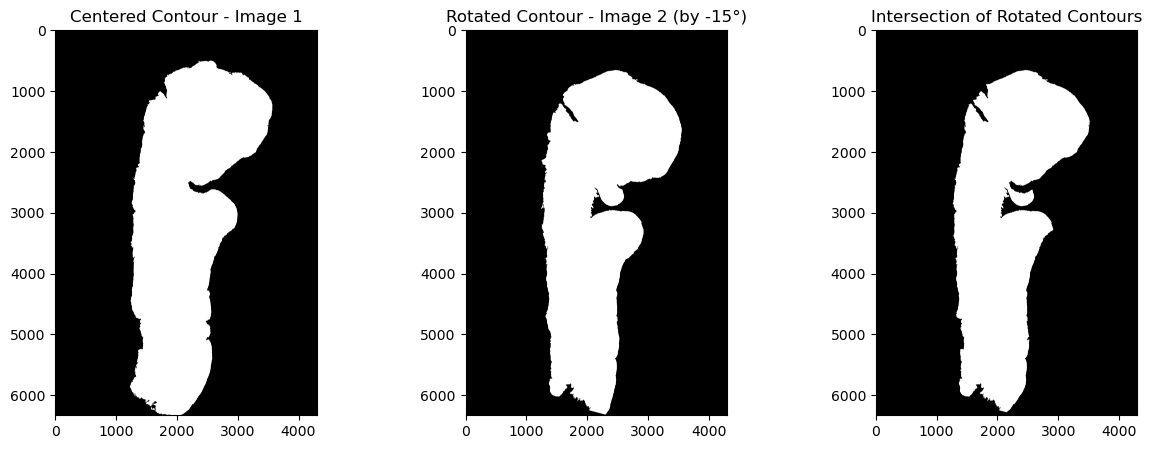

In [6]:
# current best
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Function to find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Function to fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Function to calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Function to center the image based on center of mass (centering in both axes)
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Function to rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Function to pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    h, w = image.shape
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left
    return cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

# Function to find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(-30, 31, 5)):  # Restrict rotation range from -30° to +30°
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

# Load the images (Ensure to use your .tif files)
img1 = cv2.imread('Images/TIF/h2114153melan2.tif', 0)
img2 = cv2.imread('Images/TIF/h2114153sox10.tif', 0) 

# Edge Detection using Canny
edges1 = cv2.Canny(img1, 50, 100)
edges2 = cv2.Canny(img2, 50, 100)

# Clean the edges
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours and select the largest one
contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour1 = find_largest_contour(contours1)
largest_contour2 = find_largest_contour(contours2)

# Fill the largest contours to create masks
mask1 = fill_contour(cleaned_edges1.shape, largest_contour1)
mask2 = fill_contour(cleaned_edges2.shape, largest_contour2)

# Center the filled masks
centered_mask1 = center_image(mask1)
centered_mask2 = center_image(mask2)

# Get maximum width and height to resize both images
max_width = max(centered_mask1.shape[1], centered_mask2.shape[1])
max_height = max(centered_mask1.shape[0], centered_mask2.shape[0])

# Resize both masks to the same size with symmetrical padding
centered_mask1 = pad_to_size(centered_mask1, (max_width, max_height))
centered_mask2 = pad_to_size(centered_mask2, (max_width, max_height))

# Find the best rotation for mask2 that maximizes overlap with mask1
best_overlap, best_angle = find_best_rotation(centered_mask1, centered_mask2)

# Rotate mask2 by the best angle
rotated_mask2 = rotate_image(centered_mask2, best_angle)

# Compare the final masks pixel-wise
intersection = cv2.bitwise_and(centered_mask1, rotated_mask2)
union = cv2.bitwise_or(centered_mask1, rotated_mask2)
final_similarity_score = np.sum(intersection) / np.sum(union)

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Print the best angle, similarity score, and decision
print(f"Best rotation angle: {best_angle}°")
if final_similarity_score > similarity_threshold:
    print(f"The images are similar. Final pixel overlap score: {final_similarity_score}")
else:
    print(f"The images are not similar enough. Final pixel overlap score: {final_similarity_score}")

# Display the masks and comparison result
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Centered Contour - Image 1')
plt.imshow(centered_mask1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Rotated Contour - Image 2 (by {best_angle}°)')
plt.imshow(rotated_mask2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Intersection of Rotated Contours')
plt.imshow(intersection, cmap='gray')

plt.show()

### A weird in between, rotation and best

Best rotation angle: 5°
The images are not similar enough. Final pixel overlap score: 0.7091880810751678


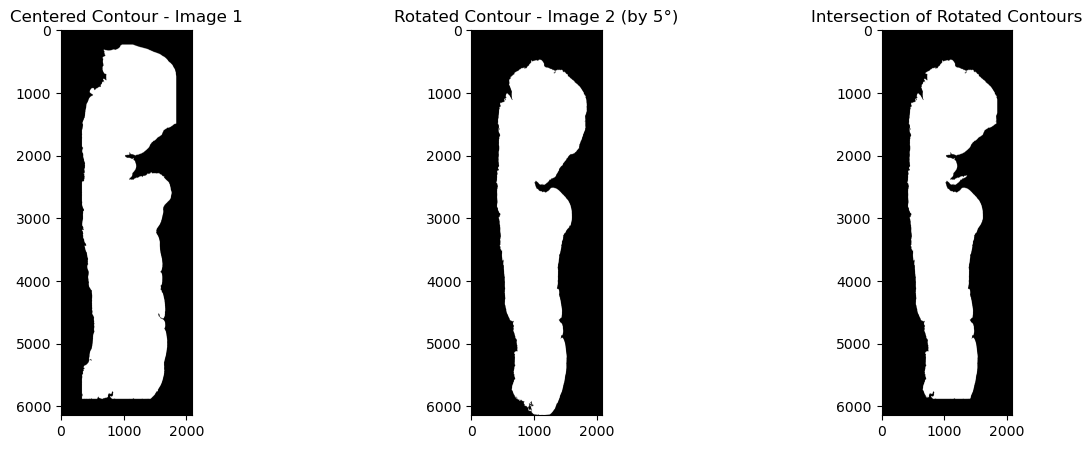

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Function to find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Function to fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Function to calculate the bounding box of a contour
def get_bounding_box(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return x, y, w, h

# Function to scale an image based on bounding box dimensions
def scale_image_to_match_reference(reference_contour, target_contour, target_image):
    ref_x, ref_y, ref_w, ref_h = get_bounding_box(reference_contour)
    tar_x, tar_y, tar_w, tar_h = get_bounding_box(target_contour)
    
    scale_factor_w = ref_w / tar_w
    scale_factor_h = ref_h / tar_h
    
    return cv2.resize(target_image, (int(target_image.shape[1] * scale_factor_w),
                                     int(target_image.shape[0] * scale_factor_h)), interpolation=cv2.INTER_AREA)

# Function to calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Function to center the image based on center of mass (centering in both axes)
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Function to rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Function to pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    h, w = image.shape
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left
    return cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

# Function to find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(-30, 31, 5)):  # Restrict rotation range from -30° to +30°
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

# Load the images (Ensure to use your .tif files)
img1 = cv2.imread('Images/TIF/h2114153h&e.tif', 0) 
img2 = cv2.imread('Images/TIF/h2114153melan2.tif', 0) 

# Edge Detection using Canny
edges1 = cv2.Canny(img1, 50, 100)
edges2 = cv2.Canny(img2, 50, 100)

# Clean the edges
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours and select the largest one
contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour1 = find_largest_contour(contours1)
largest_contour2 = find_largest_contour(contours2)

# Scale the second image based on the bounding box of the largest contour of the first image
img2_resized = scale_image_to_match_reference(largest_contour1, largest_contour2, img2)

# Recompute edges and contours for the scaled image
edges2_rescaled = cv2.Canny(img2_resized, 50, 100)
cleaned_edges2_rescaled = clean_edges(edges2_rescaled)
contours2_rescaled, _ = cv2.findContours(cleaned_edges2_rescaled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour2_rescaled = find_largest_contour(contours2_rescaled)

# Fill the largest contours to create masks
mask1 = fill_contour(cleaned_edges1.shape, largest_contour1)
mask2_rescaled = fill_contour(cleaned_edges2_rescaled.shape, largest_contour2_rescaled)

# Center the filled masks
centered_mask1 = center_image(mask1)
centered_mask2_rescaled = center_image(mask2_rescaled)

# Get maximum width and height to resize both images
max_width = max(centered_mask1.shape[1], centered_mask2_rescaled.shape[1])
max_height = max(centered_mask1.shape[0], centered_mask2_rescaled.shape[0])

# Resize both masks to the same size
centered_mask1 = pad_to_size(centered_mask1, (max_width, max_height))
centered_mask2_rescaled = pad_to_size(centered_mask2_rescaled, (max_width, max_height))

# Find the best rotation for mask2 that maximizes overlap with mask1
best_overlap, best_angle = find_best_rotation(centered_mask1, centered_mask2_rescaled)

# Rotate mask2 by the best angle
rotated_mask2 = rotate_image(centered_mask2_rescaled, best_angle)

# Compare the final masks pixel-wise
intersection = cv2.bitwise_and(centered_mask1, rotated_mask2)
union = cv2.bitwise_or(centered_mask1, rotated_mask2)
final_similarity_score = np.sum(intersection) / np.sum(union)

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Print the best angle, similarity score, and decision
print(f"Best rotation angle: {best_angle}°")
if final_similarity_score > similarity_threshold:
    print(f"The images are similar. Final pixel overlap score: {final_similarity_score}")
else:
    print(f"The images are not similar enough. Final pixel overlap score: {final_similarity_score}")

# Display the masks and comparison result
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Centered Contour - Image 1')
plt.imshow(centered_mask1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Rotated Contour - Image 2 (by {best_angle}°)')
plt.imshow(rotated_mask2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Intersection of Rotated Contours')
plt.imshow(intersection, cmap='gray')

plt.show()


### Rotation Limits
- But Borders/Edges are weird

Best rotation angle: 5°
The images are not similar enough. Final pixel overlap score: 0.5187501443065413


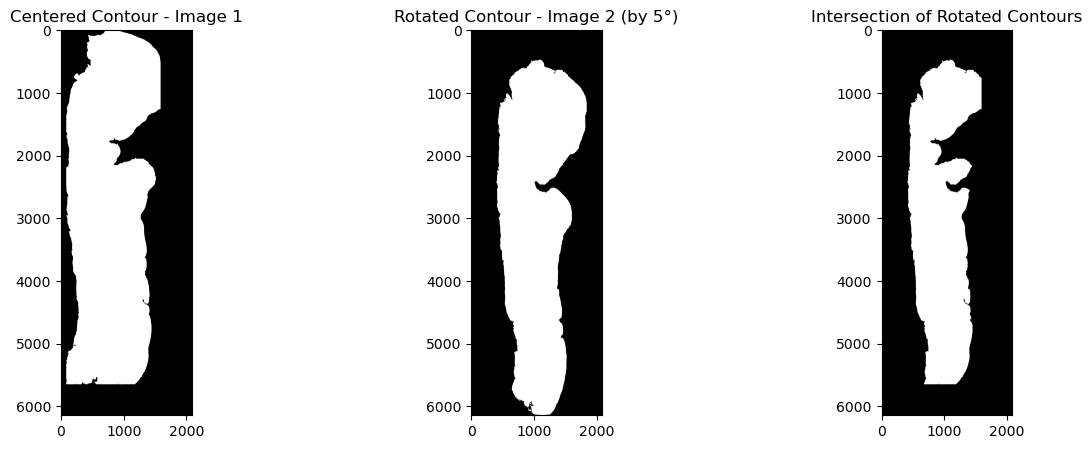

In [11]:
# rotation limits, trying not to overotate
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Function to find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Function to fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Function to calculate the bounding box of a contour
def get_bounding_box(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return x, y, w, h

# Function to scale an image based on bounding box dimensions
def scale_image_to_match_reference(reference_contour, target_contour, target_image):
    ref_x, ref_y, ref_w, ref_h = get_bounding_box(reference_contour)
    tar_x, tar_y, tar_w, tar_h = get_bounding_box(target_contour)
    
    scale_factor_w = ref_w / tar_w
    scale_factor_h = ref_h / tar_h
    
    return cv2.resize(target_image, (int(target_image.shape[1] * scale_factor_w),
                                     int(target_image.shape[0] * scale_factor_h)), interpolation=cv2.INTER_AREA)

# Function to calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Function to center the image based on center of mass
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Function to rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Function to pad an image to match a target size
def pad_to_size(image, target_size):
    h, w = image.shape
    pad_height = max(0, target_size[1] - h)
    pad_width = max(0, target_size[0] - w)
    return cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=0)

# Function to find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(-30, 31, 5)):
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

# Load the images (Ensure to use your .tif files)
img1 = cv2.imread('Images/TIF/h2114153h&e.tif', 0) 
img2 = cv2.imread('Images/TIF/h2114153melan2.tif', 0) 

# Edge Detection using Canny
edges1 = cv2.Canny(img1, 50, 100)
edges2 = cv2.Canny(img2, 50, 100)

# Clean the edges
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours and select the largest one
contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour1 = find_largest_contour(contours1)
largest_contour2 = find_largest_contour(contours2)

# Scale the second image based on the bounding box of the largest contour of the first image
img2_resized = scale_image_to_match_reference(largest_contour1, largest_contour2, img2)

# Recompute edges and contours for the scaled image
edges2_rescaled = cv2.Canny(img2_resized, 50, 100)
cleaned_edges2_rescaled = clean_edges(edges2_rescaled)
contours2_rescaled, _ = cv2.findContours(cleaned_edges2_rescaled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour2_rescaled = find_largest_contour(contours2_rescaled)

# Fill the largest contours to create masks
mask1 = fill_contour(cleaned_edges1.shape, largest_contour1)
mask2_rescaled = fill_contour(cleaned_edges2_rescaled.shape, largest_contour2_rescaled)

# Center the filled masks
centered_mask1 = center_image(mask1)
centered_mask2_rescaled = center_image(mask2_rescaled)

# Get maximum width and height to resize both images
max_width = max(centered_mask1.shape[1], centered_mask2_rescaled.shape[1])
max_height = max(centered_mask1.shape[0], centered_mask2_rescaled.shape[0])

# Resize both masks to the same size
centered_mask1 = pad_to_size(centered_mask1, (max_width, max_height))
centered_mask2_rescaled = pad_to_size(centered_mask2_rescaled, (max_width, max_height))

# Find the best rotation for mask2 that maximizes overlap with mask1
best_overlap, best_angle = find_best_rotation(centered_mask1, centered_mask2_rescaled)

# Rotate mask2 by the best angle
rotated_mask2 = rotate_image(centered_mask2_rescaled, best_angle)

# Compare the final masks pixel-wise
intersection = cv2.bitwise_and(centered_mask1, rotated_mask2)
union = cv2.bitwise_or(centered_mask1, rotated_mask2)
final_similarity_score = np.sum(intersection) / np.sum(union)

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Print the best angle, similarity score, and decision
print(f"Best rotation angle: {best_angle}°")
if final_similarity_score > similarity_threshold:
    print(f"The images are similar. Final pixel overlap score: {final_similarity_score}")
else:
    print(f"The images are not similar enough. Final pixel overlap score: {final_similarity_score}")

# Display the masks and comparison result
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Centered Contour - Image 1')
plt.imshow(centered_mask1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Rotated Contour - Image 2 (by {best_angle}°)')
plt.imshow(rotated_mask2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Intersection of Rotated Contours')
plt.imshow(intersection, cmap='gray')

plt.show()


### Crazy over-rotated

Best rotation angle: 180°
The images are not similar enough. Final pixel overlap score: 0.5331052941443448


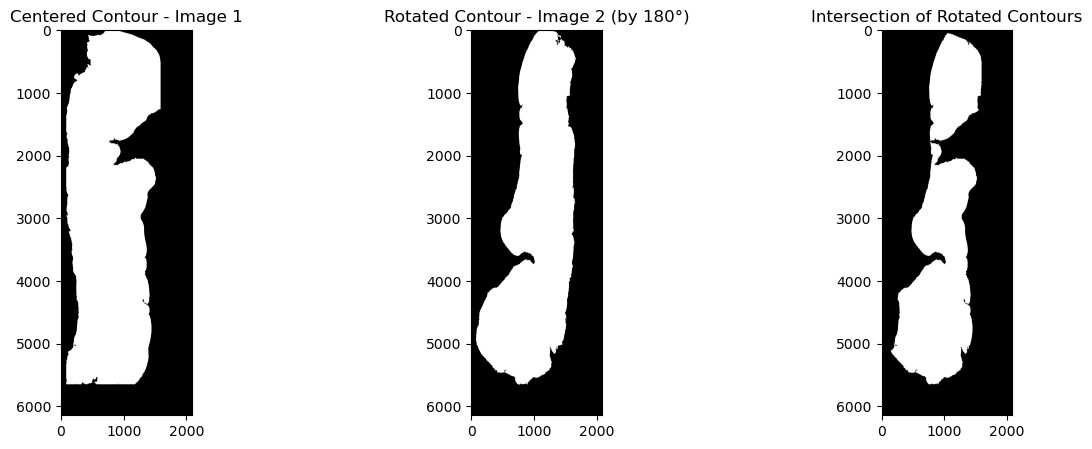

In [5]:
# crazy over-rotated
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Function to find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Function to fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Function to calculate the bounding box of a contour
def get_bounding_box(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return x, y, w, h

# Function to scale an image based on bounding box dimensions
def scale_image_to_match_reference(reference_contour, target_contour, target_image):
    ref_x, ref_y, ref_w, ref_h = get_bounding_box(reference_contour)
    tar_x, tar_y, tar_w, tar_h = get_bounding_box(target_contour)
    
    scale_factor_w = ref_w / tar_w
    scale_factor_h = ref_h / tar_h
    
    return cv2.resize(target_image, (int(target_image.shape[1] * scale_factor_w),
                                     int(target_image.shape[0] * scale_factor_h)), interpolation=cv2.INTER_AREA)

# Function to calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Function to center the image based on center of mass
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Function to rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Function to pad an image to match a target size
def pad_to_size(image, target_size):
    h, w = image.shape
    pad_height = max(0, target_size[1] - h)
    pad_width = max(0, target_size[0] - w)
    return cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=0)

# Function to find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(0, 360, 10)):
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

# Load the images (Ensure to use your .tif files)
img1 = cv2.imread('Images/TIF/h2114153h&e.tif', 0) 
img2 = cv2.imread('Images/TIF/h2114153melan2.tif', 0) 

# Edge Detection using Canny
edges1 = cv2.Canny(img1, 50, 100)
edges2 = cv2.Canny(img2, 50, 100)

# Clean the edges
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours and select the largest one
contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour1 = find_largest_contour(contours1)
largest_contour2 = find_largest_contour(contours2)

# Scale the second image based on the bounding box of the largest contour of the first image
img2_resized = scale_image_to_match_reference(largest_contour1, largest_contour2, img2)

# Recompute edges and contours for the scaled image
edges2_rescaled = cv2.Canny(img2_resized, 50, 100)
cleaned_edges2_rescaled = clean_edges(edges2_rescaled)
contours2_rescaled, _ = cv2.findContours(cleaned_edges2_rescaled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour2_rescaled = find_largest_contour(contours2_rescaled)

# Fill the largest contours to create masks
mask1 = fill_contour(cleaned_edges1.shape, largest_contour1)
mask2_rescaled = fill_contour(cleaned_edges2_rescaled.shape, largest_contour2_rescaled)

# Center the filled masks
centered_mask1 = center_image(mask1)
centered_mask2_rescaled = center_image(mask2_rescaled)

# Get maximum width and height to resize both images
max_width = max(centered_mask1.shape[1], centered_mask2_rescaled.shape[1])
max_height = max(centered_mask1.shape[0], centered_mask2_rescaled.shape[0])

# Resize both masks to the same size
centered_mask1 = pad_to_size(centered_mask1, (max_width, max_height))
centered_mask2_rescaled = pad_to_size(centered_mask2_rescaled, (max_width, max_height))

# Find the best rotation for mask2 that maximizes overlap with mask1
best_overlap, best_angle = find_best_rotation(centered_mask1, centered_mask2_rescaled)

# Rotate mask2 by the best angle
rotated_mask2 = rotate_image(centered_mask2_rescaled, best_angle)

# Compare the final masks pixel-wise
intersection = cv2.bitwise_and(centered_mask1, rotated_mask2)
union = cv2.bitwise_or(centered_mask1, rotated_mask2)
final_similarity_score = np.sum(intersection) / np.sum(union)

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Print the best angle, similarity score, and decision
print(f"Best rotation angle: {best_angle}°")
if final_similarity_score > similarity_threshold:
    print(f"The images are similar. Final pixel overlap score: {final_similarity_score}")
else:
    print(f"The images are not similar enough. Final pixel overlap score: {final_similarity_score}")

# Display the masks and comparison result
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Centered Contour - Image 1')
plt.imshow(centered_mask1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Rotated Contour - Image 2 (by {best_angle}°)')
plt.imshow(rotated_mask2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Intersection of Rotated Contours')
plt.imshow(intersection, cmap='gray')

plt.show()


### "Optimal size" method
- Got rid of fixed size
- Weird tradeoffs

Best rotation angle: 20°
The images are not similar enough. Final pixel overlap score: 0.567426421450358


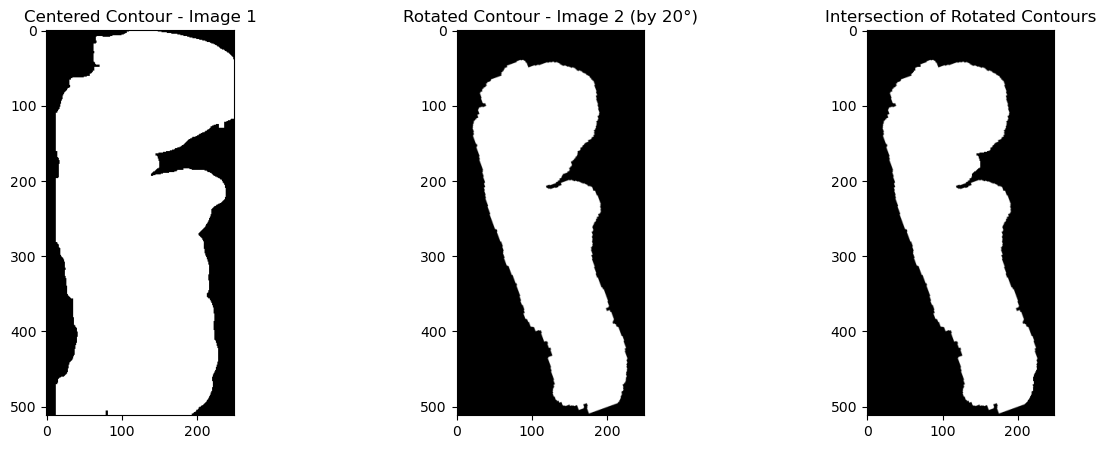

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_to_optimal_size(img1, img2, max_size=(512, 512)):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    aspect_ratio1 = w1 / h1
    aspect_ratio2 = w2 / h2

    if aspect_ratio1 > aspect_ratio2:
        new_w = max_size[0]
        new_h = int(new_w / aspect_ratio1)
    else:
        new_h = max_size[1]
        new_w = int(new_h * aspect_ratio2)

    img1_resized = cv2.resize(img1, (new_w, new_h), interpolation=cv2.INTER_AREA)
    img2_resized = cv2.resize(img2, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    return img1_resized, img2_resized


# Function to clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Function to find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Function to fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Function to calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Function to center the image based on center of mass
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask


def rotate_image_automated(image, angle, target_size):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return rotated_image


def find_best_rotation(mask1, mask2, angles=np.arange(0, 360, 10)):
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image_automated(mask2, angle, target_size=(mask1.shape[1], mask1.shape[0]))   
        if mask1.shape != rotated_mask2.shape:
            print("Error: Masks must have the same dimensions.")
            return 0, 0

        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle


# Load the images
img1 = cv2.imread('Images/TIF/h2114153h&e.tif', 0) 
img2 = cv2.imread('Images/TIF/h2114153melan2.tif', 0) 

# Automatically resize both images to the same optimal size
img1_resized, img2_resized = resize_to_optimal_size(img1, img2, max_size=(512, 512))


# Edge Detection using Canny
edges1 = cv2.Canny(img1_resized, 50, 100)
edges2 = cv2.Canny(img2_resized, 50, 100)

# Clean the edges
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours and select the largest one
contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour1 = find_largest_contour(contours1)
largest_contour2 = find_largest_contour(contours2)

# Fill the largest contours to create masks
mask1 = fill_contour(cleaned_edges1.shape, largest_contour1)
mask2 = fill_contour(cleaned_edges2.shape, largest_contour2)

# Center the filled masks
centered_mask1 = center_image(mask1)
centered_mask2 = center_image(mask2)

# Find the best rotation for mask2 that maximizes overlap with mask1
best_overlap, best_angle = find_best_rotation(centered_mask1, centered_mask2)

# **Rotate mask2** by the best angle after determining the best rotation
rotated_mask2 = rotate_image_automated(centered_mask2, best_angle, target_size=centered_mask1.shape[:2])

# Compare the final masks pixel-wise
intersection = cv2.bitwise_and(centered_mask1, rotated_mask2)
union = cv2.bitwise_or(centered_mask1, rotated_mask2)
final_similarity_score = np.sum(intersection) / np.sum(union)

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Print the best angle, similarity score, and decision
print(f"Best rotation angle: {best_angle}°")
if final_similarity_score > similarity_threshold:
    print(f"The images are similar. Final pixel overlap score: {final_similarity_score}")
else:
    print(f"The images are not similar enough. Final pixel overlap score: {final_similarity_score}")

# Display the masks and comparison result
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Centered Contour - Image 1')
plt.imshow(centered_mask1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Rotated Contour - Image 2 (by {best_angle}°)')
plt.imshow(rotated_mask2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Intersection of Rotated Contours')
plt.imshow(intersection, cmap='gray')

plt.show()


### Raw .tif 
- Issues with sizes, distortion

Best rotation angle: 20°
The images are not similar enough. Final pixel overlap score: 0.5584300294883132


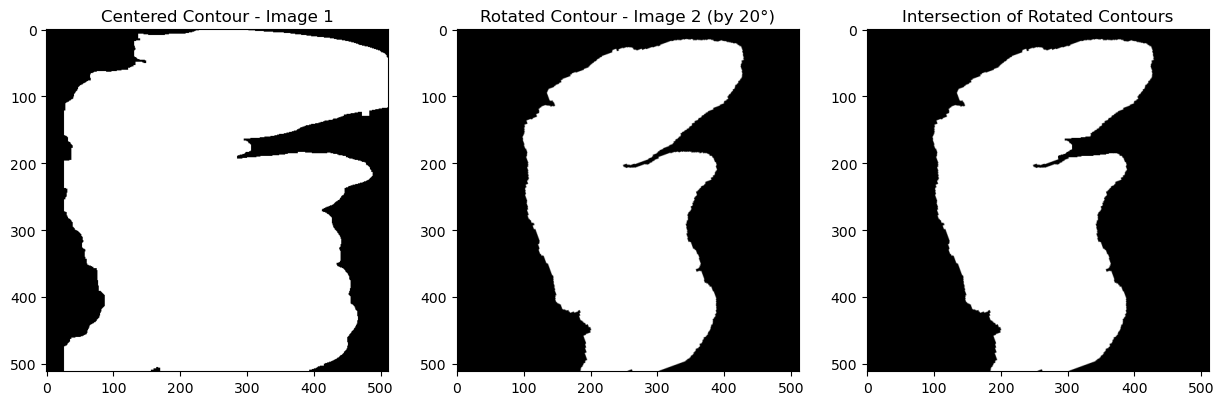

In [4]:
# RAW TIFs
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to resize both images to a fixed size
def resize_to_fixed_size(img, size=(512, 512)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

# Function to clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Function to find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Function to fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Function to calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Function to center the image based on center of mass
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Function to rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Function to find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(0, 360, 10)):
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

# Load the images
img1 = cv2.imread('Images/TIF/h2114153h&e.tif', 0) 
img2 = cv2.imread('Images/TIF/h2114153melan2.tif', 0) 

# Resize images to a fixed size (e.g., 512x512)
img1_resized = resize_to_fixed_size(img1)
img2_resized = resize_to_fixed_size(img2)

# Edge Detection using Canny
edges1 = cv2.Canny(img1_resized, 50, 100)
edges2 = cv2.Canny(img2_resized, 50, 100)

# Clean the edges
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours and select the largest one
contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour1 = find_largest_contour(contours1)
largest_contour2 = find_largest_contour(contours2)

# Fill the largest contours to create masks
mask1 = fill_contour(cleaned_edges1.shape, largest_contour1)
mask2 = fill_contour(cleaned_edges2.shape, largest_contour2)

# Center the filled masks
centered_mask1 = center_image(mask1)
centered_mask2 = center_image(mask2)

# Find the best rotation for mask2 that maximizes overlap with mask1
best_overlap, best_angle = find_best_rotation(centered_mask1, centered_mask2)

# Rotate mask2 by the best angle
rotated_mask2 = rotate_image(centered_mask2, best_angle)

# Compare the final masks pixel-wise
intersection = cv2.bitwise_and(centered_mask1, rotated_mask2)
union = cv2.bitwise_or(centered_mask1, rotated_mask2)
final_similarity_score = np.sum(intersection) / np.sum(union)

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Print the best angle, similarity score, and decision
print(f"Best rotation angle: {best_angle}°")
if final_similarity_score > similarity_threshold:
    print(f"The images are similar. Final pixel overlap score: {final_similarity_score}")
else:
    print(f"The images are not similar enough. Final pixel overlap score: {final_similarity_score}")

# Display the masks and comparison result
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Centered Contour - Image 1')
plt.imshow(centered_mask1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Rotated Contour - Image 2 (by {best_angle}°)')
plt.imshow(rotated_mask2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Intersection of Rotated Contours')
plt.imshow(intersection, cmap='gray')

plt.show()


# PNG from here down- Baron's Work

Best rotation angle: 340°
The images are not similar enough. Final pixel overlap score: 0.6508643636246535


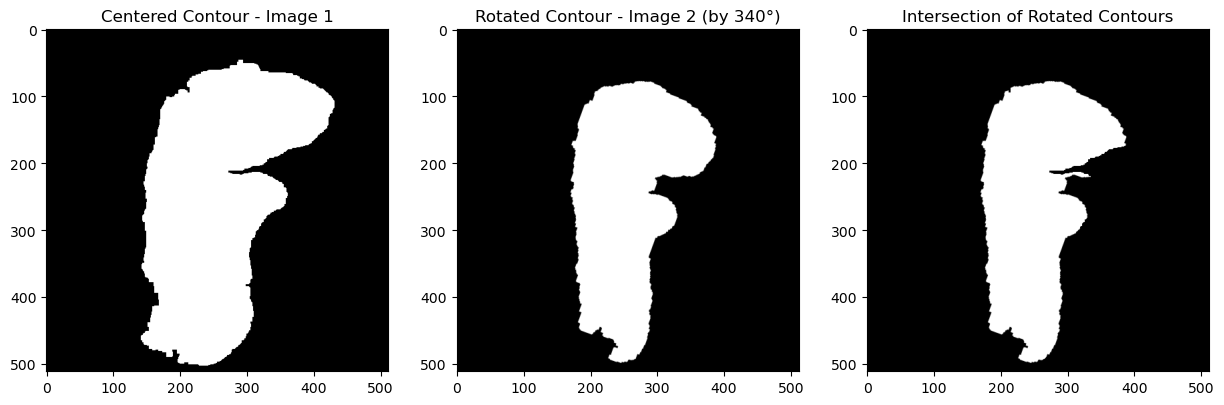

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to resize both images to a fixed size
def resize_to_fixed_size(img, size=(512, 512)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

# Function to clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Function to find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Function to fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Function to calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Function to center the image based on center of mass
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Function to rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Function to find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(0, 360, 10)):
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

# Load the images
img1 = cv2.imread('Images/PNG/melan1.png', 0)  # Image 1
img2 = cv2.imread('Images/PNG/sox1.png', 0)  # Image 2

# Resize images to a fixed size (e.g., 512x512)
img1_resized = resize_to_fixed_size(img1)
img2_resized = resize_to_fixed_size(img2)

# Edge Detection using Canny
edges1 = cv2.Canny(img1_resized, 50, 100)
edges2 = cv2.Canny(img2_resized, 50, 100)

# Clean the edges
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours and select the largest one
contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour1 = find_largest_contour(contours1)
largest_contour2 = find_largest_contour(contours2)

# Fill the largest contours to create masks
mask1 = fill_contour(cleaned_edges1.shape, largest_contour1)
mask2 = fill_contour(cleaned_edges2.shape, largest_contour2)

# Center the filled masks
centered_mask1 = center_image(mask1)
centered_mask2 = center_image(mask2)

# Find the best rotation for mask2 that maximizes overlap with mask1
best_overlap, best_angle = find_best_rotation(centered_mask1, centered_mask2)

# Rotate mask2 by the best angle
rotated_mask2 = rotate_image(centered_mask2, best_angle)

# Compare the final masks pixel-wise
intersection = cv2.bitwise_and(centered_mask1, rotated_mask2)
union = cv2.bitwise_or(centered_mask1, rotated_mask2)
final_similarity_score = np.sum(intersection) / np.sum(union)

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Print the best angle, similarity score, and decision
print(f"Best rotation angle: {best_angle}°")
if final_similarity_score > similarity_threshold:
    print(f"The images are similar. Final pixel overlap score: {final_similarity_score}")
else:
    print(f"The images are not similar enough. Final pixel overlap score: {final_similarity_score}")

# Display the masks and comparison result
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Centered Contour - Image 1')
plt.imshow(centered_mask1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Rotated Contour - Image 2 (by {best_angle}°)')
plt.imshow(rotated_mask2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Intersection of Rotated Contours')
plt.imshow(intersection, cmap='gray')

plt.show()


The images are not similar enough. Hu diff: 0.023417234067969604, Shape similarity: 0.17788903254518112


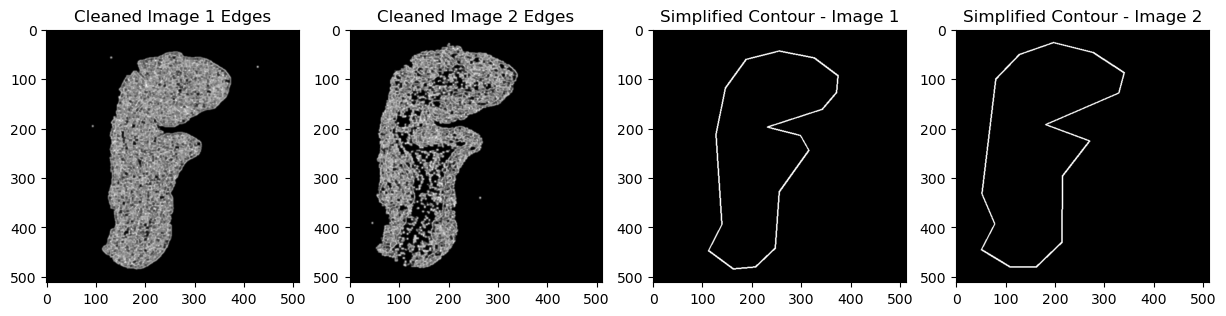

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to resize both images to a fixed size
def resize_to_fixed_size(img, size=(512, 512)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

# Function to clean edges using morphological operations
def clean_edges(edges):
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    
    # Apply dilation followed by erosion to focus on the outer contour
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    
    return cleaned_edges

# Function to find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Function to simplify a contour to reduce noise
def simplify_contour(contour, epsilon_factor=0.01):
    # Calculate epsilon value based on contour perimeter (arcLength)
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    simplified_contour = cv2.approxPolyDP(contour, epsilon, True)
    return simplified_contour

# Function to compare shapes using Hu moments (rotation invariant)
def compare_hu_moments(contour1, contour2):
    moments1 = cv2.moments(contour1)
    moments2 = cv2.moments(contour2)
    
    hu1 = cv2.HuMoments(moments1).flatten()
    hu2 = cv2.HuMoments(moments2).flatten()
    
    hu_diff = np.sum(np.abs(hu1 - hu2))
    return hu_diff

# Function to compare contour shapes using cv2.matchShapes
def compare_contour_shapes(contour1, contour2):
    shape_similarity = cv2.matchShapes(contour1, contour2, cv2.CONTOURS_MATCH_I1, 0.0)
    return shape_similarity

# Load the images
img1 = cv2.imread('Images/PNG/h&e1.png', 0)  # Image 1
img2 = cv2.imread('Images/PNG/melan1.png', 0)  # Image 2

# Resize images to a fixed size (e.g., 512x512)
img1_resized = resize_to_fixed_size(img1)
img2_resized = resize_to_fixed_size(img2)

# Edge Detection using Canny (with adjusted thresholds)
edges1 = cv2.Canny(img1_resized, 50, 100)
edges2 = cv2.Canny(img2_resized, 50, 100)

# Clean the edges to reduce noise
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours (outermost borders) on cleaned images
contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Keep only the largest contour for each image
largest_contour1 = find_largest_contour(contours1)
largest_contour2 = find_largest_contour(contours2)

# Simplify the contours to reduce noise
simplified_contour1 = simplify_contour(largest_contour1)
simplified_contour2 = simplify_contour(largest_contour2)

# Create blank images to draw the simplified contours
contour_img1 = np.zeros_like(cleaned_edges1)
contour_img2 = np.zeros_like(cleaned_edges2)

# Draw the simplified contours
cv2.drawContours(contour_img1, [simplified_contour1], -1, (255), 2)
cv2.drawContours(contour_img2, [simplified_contour2], -1, (255), 2)

# Compare shapes using both Hu moments (rotation invariant) and cv2.matchShapes
hu_diff = compare_hu_moments(simplified_contour1, simplified_contour2)
shape_similarity = compare_contour_shapes(simplified_contour1, simplified_contour2)

# Set thresholds for both metrics
hu_threshold = 0.005  # Hu moments threshold
shape_threshold = 0.1  # Shape similarity threshold

# Decision based on both Hu moments and shape matching
if hu_diff < hu_threshold and shape_similarity < shape_threshold:
    print(f"The images are similar. Hu diff: {hu_diff}, Shape similarity: {shape_similarity}")
else:
    print(f"The images are not similar enough. Hu diff: {hu_diff}, Shape similarity: {shape_similarity}")

# Display the original edge-detected images and contour images
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title('Cleaned Image 1 Edges')
plt.imshow(cleaned_edges1, cmap='gray')

plt.subplot(1, 4, 2)
plt.title('Cleaned Image 2 Edges')
plt.imshow(cleaned_edges2, cmap='gray')

plt.subplot(1, 4, 3)
plt.title('Simplified Contour - Image 1')
plt.imshow(contour_img1, cmap='gray')

plt.subplot(1, 4, 4)
plt.title('Simplified Contour - Image 2')
plt.imshow(contour_img2, cmap='gray')

plt.show()


The images are similar with an SSIM score of: 0.8828988789359307


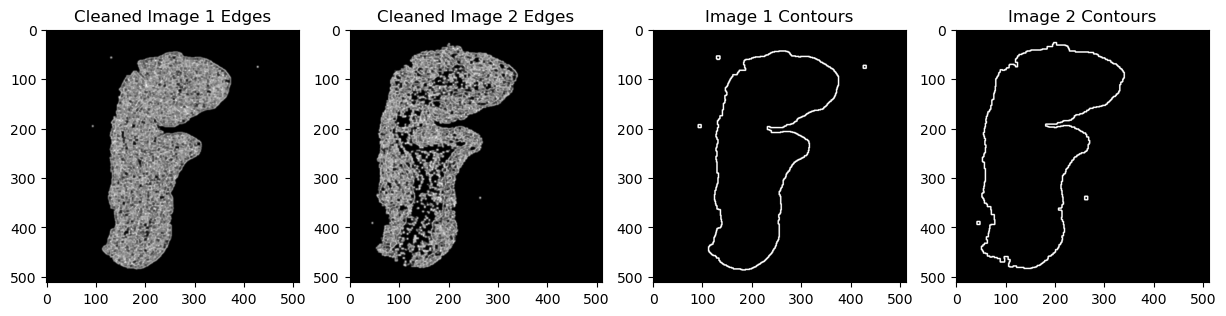

In [16]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Function to resize both images to a fixed size
def resize_to_fixed_size(img, size=(512, 512)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

# Function to clean edges using morphological operations
def clean_edges(edges):
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    
    # Apply dilation followed by erosion to focus on the outer contour
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    
    return cleaned_edges

# Load the images
img1 = cv2.imread('Images/PNG/h&e1.png', 0)  # Image 1
img2 = cv2.imread('Images/PNG/melan1.png', 0)  # Image 2

# Resize images to a fixed size (e.g., 512x512)
img1_resized = resize_to_fixed_size(img1)
img2_resized = resize_to_fixed_size(img2)

# Edge Detection using Canny (with adjusted thresholds)
edges1 = cv2.Canny(img1_resized, 50, 100)
edges2 = cv2.Canny(img2_resized, 50, 100)

# Clean the edges to reduce noise
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours (outermost borders) on cleaned images
contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create blank images to draw the outermost contours
contour_img1 = np.zeros_like(cleaned_edges1)
contour_img2 = np.zeros_like(cleaned_edges2)

# Draw the outermost contours
cv2.drawContours(contour_img1, contours1, -1, (255), 2)
cv2.drawContours(contour_img2, contours2, -1, (255), 2)

# Compute Structural Similarity (SSIM) between the two contour images
similarity_score, diff = ssim(contour_img1, contour_img2, full=True)

# Set a threshold for considering images "similar"
ssim_threshold = 0.75
if similarity_score > ssim_threshold:
    print(f"The images are similar with an SSIM score of: {similarity_score}")
else:
    print(f"The images are not similar enough. SSIM score: {similarity_score}")

# Display the original edge-detected images, contour images, and their difference
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title('Cleaned Image 1 Edges')
plt.imshow(cleaned_edges1, cmap='gray')

plt.subplot(1, 4, 2)
plt.title('Cleaned Image 2 Edges')
plt.imshow(cleaned_edges2, cmap='gray')

plt.subplot(1, 4, 3)
plt.title('Image 1 Contours')
plt.imshow(contour_img1, cmap='gray')

plt.subplot(1, 4, 4)
plt.title('Image 2 Contours')
plt.imshow(contour_img2, cmap='gray')

plt.show()
